# Getting started with calibrated-explanations - using the WrapCalibratedExplainer class
Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
## Classification
Let us illustrate how we may use `calibrated_explanations` to generate explanations from a classifier trained on a dataset from
[www.openml.org](https://www.openml.org), which we first split into a
training and a test set using `train_test_split` from
[sklearn](https://scikit-learn.org), and then further split the
training set into a proper training set and a calibration set:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

dataset = fetch_openml(name="mammography", version=1, as_frame=True)

X = dataset.data.values.astype(float)
y = (dataset.target.values == '1').astype(int)

feature_names = dataset.feature_names

i_test = np.array([np.arange(len(y))[y==0][:4], np.arange(len(y))[y==1][:4]]).reshape(-1)
i_train = np.setdiff1d(np.arange(len(y)), i_test)
X_train, y_train = X[i_train,:], y[i_train]
X_test, y_test = X[i_test,:], y[i_test]

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25,stratify=y_train)

Before training, calibrating, predicting or explaining any instances, let us first look at the class distribution in the data set, to how imbalanced it is. 

In [32]:
print(f'number count of classes: {np.array(dataset.target.value_counts())}')
print(f'fraction of positive instances: {np.min(dataset.target.value_counts())/len(y)}')

AttributeError: module 'numpy' has no attribute 'dict'

We now create our wrapper object, using a `RandomForestClassifier` as learner. 

In [3]:
from sklearn.ensemble import RandomForestClassifier
from calibrated_explanations import WrapCalibratedExplainer, __version__

print(f"calibrated_explanations {__version__}")

classifier = WrapCalibratedExplainer(RandomForestClassifier())
display(classifier)

calibrated_explanations v0.2.1


WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=False, calibrated=False)

We now fit our model using the proper training set.

In [5]:
classifier.fit(X_prop_train, y_prop_train)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=False)

The `WrapCalibratedExplainer` class has a `predict` and a `predict_proba` method that returns the predictions and probability estimates of the underlying classifier. If the model is not yet calibrated, then the underlying models `predict` and `predict_proba` methods are used. If the model is calibrated, then the `predict` and `predict_proba` method of the calibration model is used.

In [6]:
print(f'Uncalibrated probability estimates: \n{classifier.predict_proba(X_test)}')

Uncalibrated probability estimates: 
[[1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.98 0.02]
 [0.71 0.29]
 [0.08 0.92]
 [0.39 0.61]]


c:\Users\loftuw\Anaconda3\envs\cp\lib\site-packages\calibrated_explanations\core.py:1033: Warning: The WrapCalibratedExplainer must be calibrated to get calibrated probabilities.
  warnings.warn("The WrapCalibratedExplainer must be calibrated to get calibrated probabilities.", Warning)


Before we can generate explanations, we need to calibrate our model using the calibration set. No discretizer is yet assigned.

In [7]:
classifier.calibrate(X_cal, y_cal, feature_names=feature_names)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=classification
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                )

Once the model is calibrated, the `predict` and `predict_proba` methods produce calibrated predictions and probability estimates.

In [8]:
proba, (low, high) = classifier.predict_proba(X_test, uq_interval=True)
print(f'Calibrated probability estimates: \n{proba}')
print(f'Calibrated uncertainty interval for the positive class:')
print([(low[i], high[i]) for i in range(len(low))],end='\n')

Calibrated probability estimates: 
[[0.99792961 0.00207039]
 [0.99792961 0.00207039]
 [0.99792961 0.00207039]
 [0.99792961 0.00207039]
 [0.97674419 0.02325581]
 [0.49295775 0.50704225]
 [0.14285714 0.85714286]
 [0.25531915 0.74468085]]
Calibrated uncertainty interval for the positive class:
[(0.0016570008285004142, 0.002071251035625518), (0.0016570008285004142, 0.002071251035625518), (0.0016570008285004142, 0.002071251035625518), (0.0016570008285004142, 0.002071251035625518), (0.011764705882352941, 0.023529411764705882), (0.4444444444444444, 0.5714285714285714), (0.8333333333333334, 1.0), (0.7142857142857143, 0.8333333333333334)]


#### Factual Explanations
Let us explain a test instance using our `WrapCalibratedExplainer` object. The method used to get factual explanations is `explain_factual`. Note that the discretizer is now assigned.

In [9]:
factual_explanations = classifier.explain_factual(X_test)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=classification
	                discretizer=<class 'calibrated_explanations._discretizers.BinaryEntropyDiscretizer'>
	                model=RandomForestClassifier()
	                )

Once we have the explanations, we can plot all of them using `plot_all`. Default, a regular plot, without uncertainty intervals included, is created. To include uncertainty intervals, change the parameter `uncertainty=True`. To plot only a single instance, the `plot_explanation` function can be called, submitting the index of the test instance to plot.

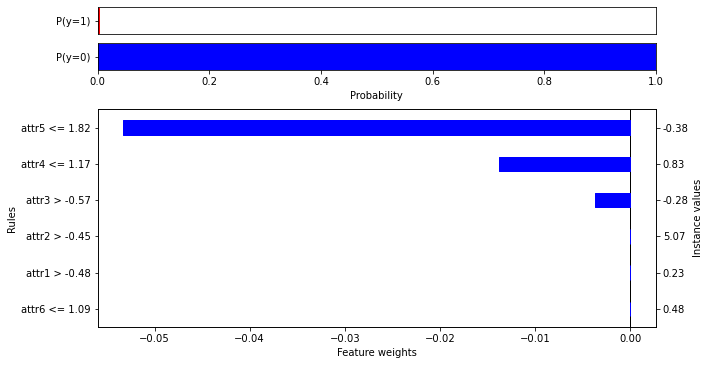

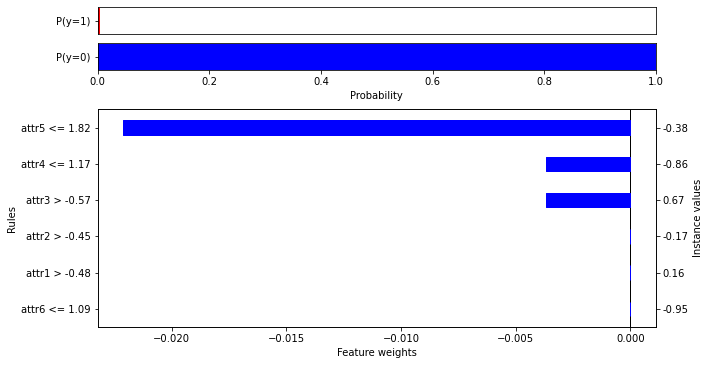

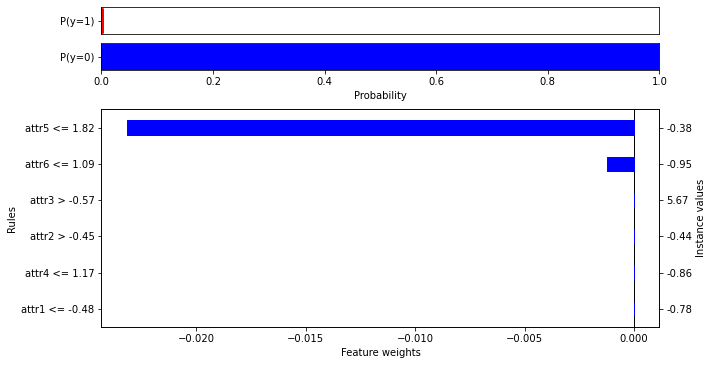

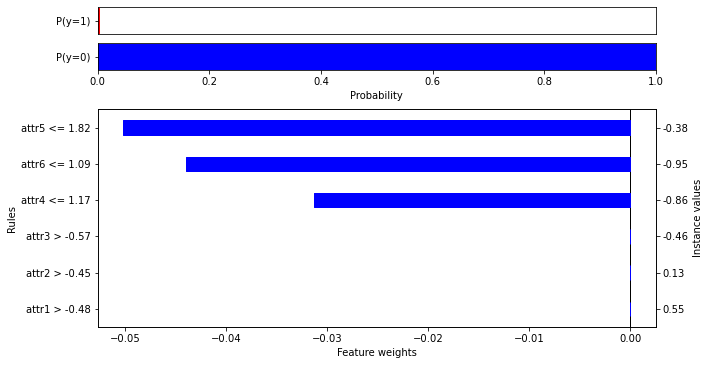

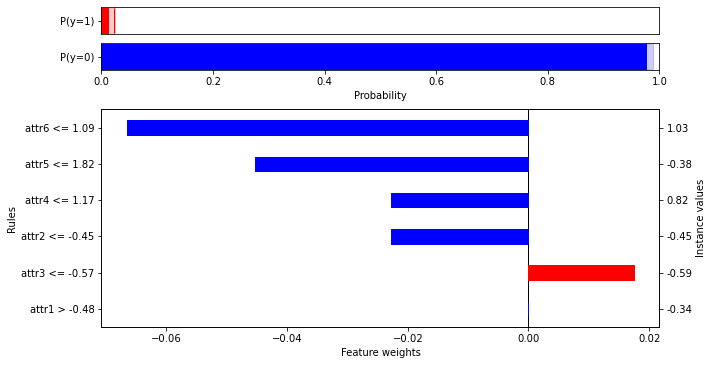

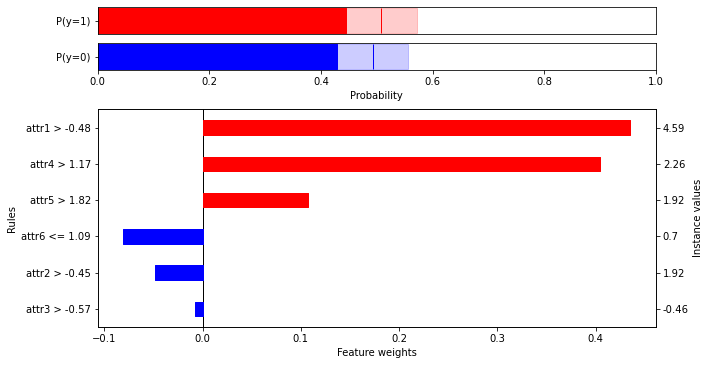

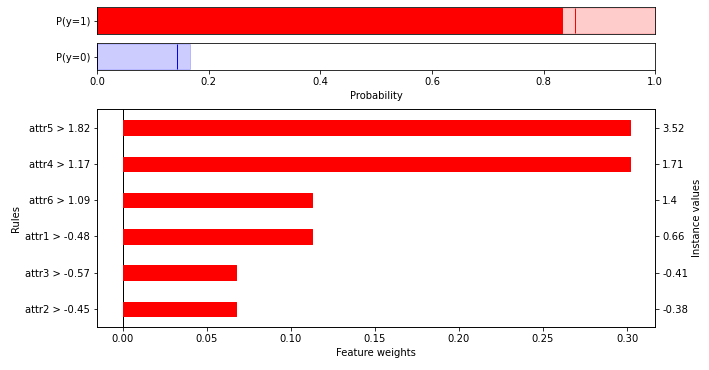

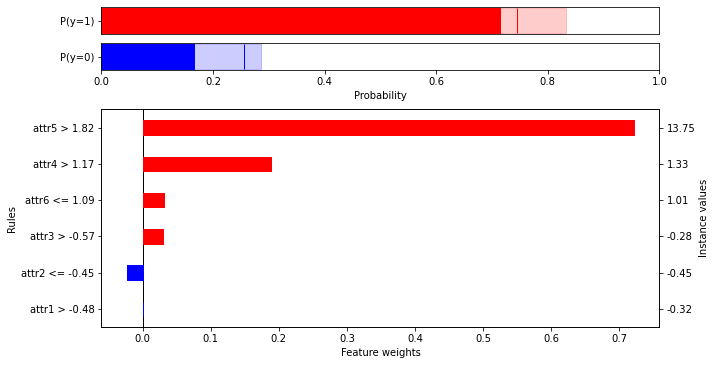

In [14]:
factual_explanations.plot_all()

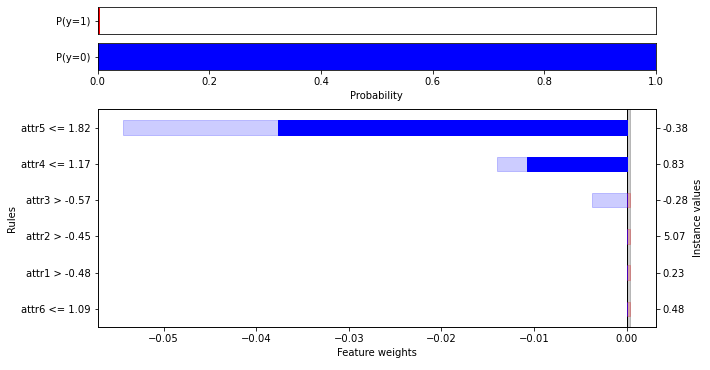

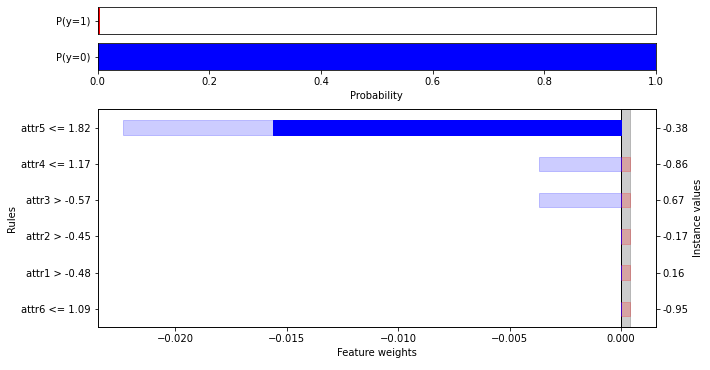

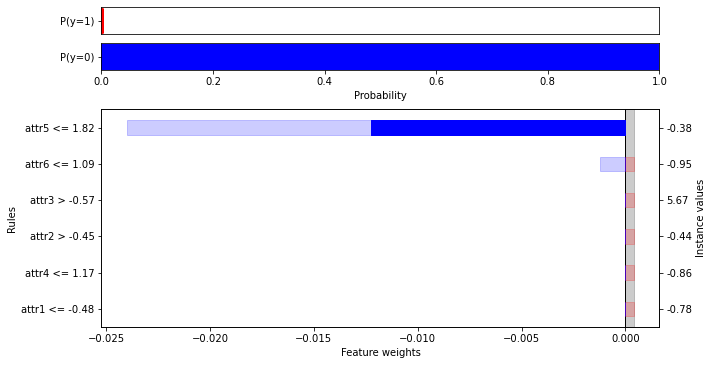

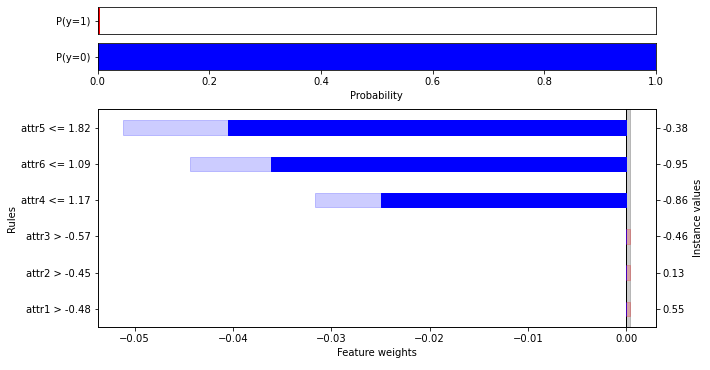

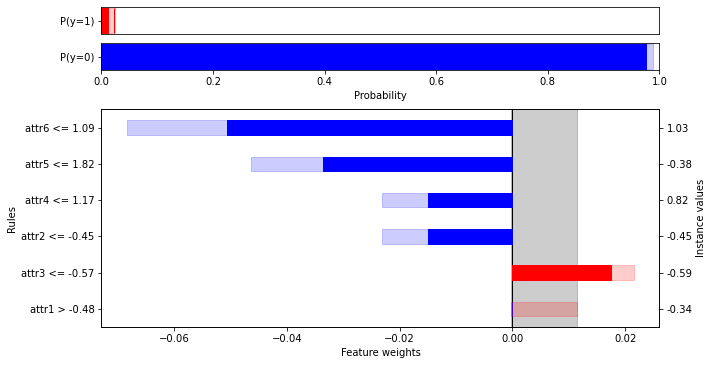

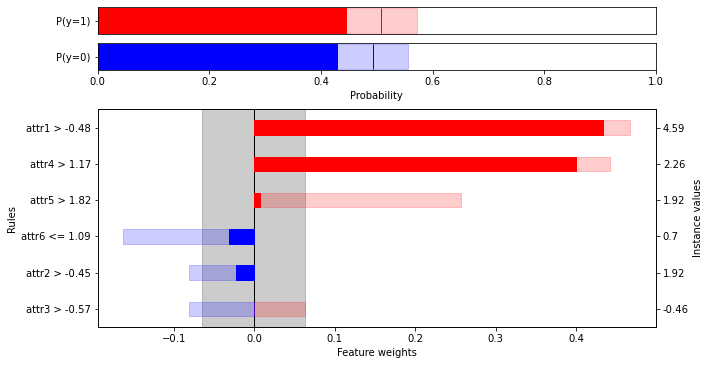

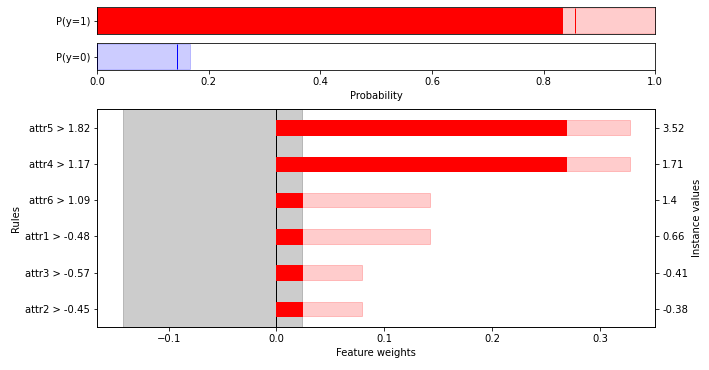

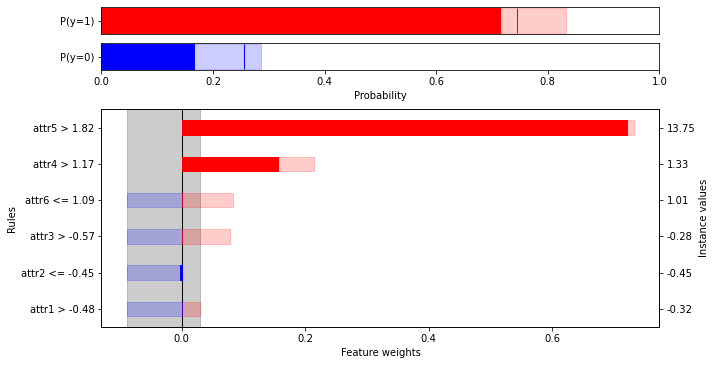

In [19]:
factual_explanations.plot_all(uncertainty=True)

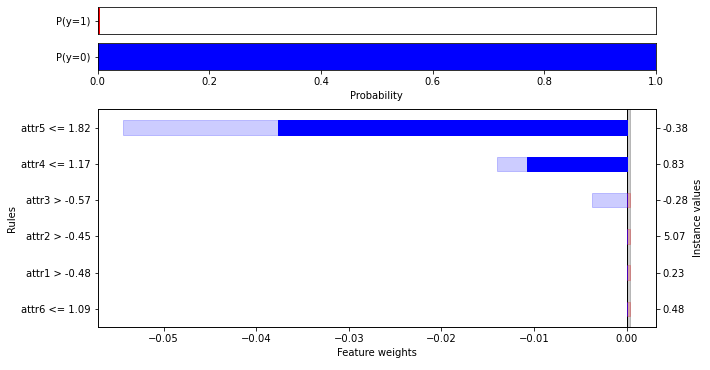

In [20]:
factual_explanations.plot_explanation(0, uncertainty=True)

You can also add and remove conjunctive rules.

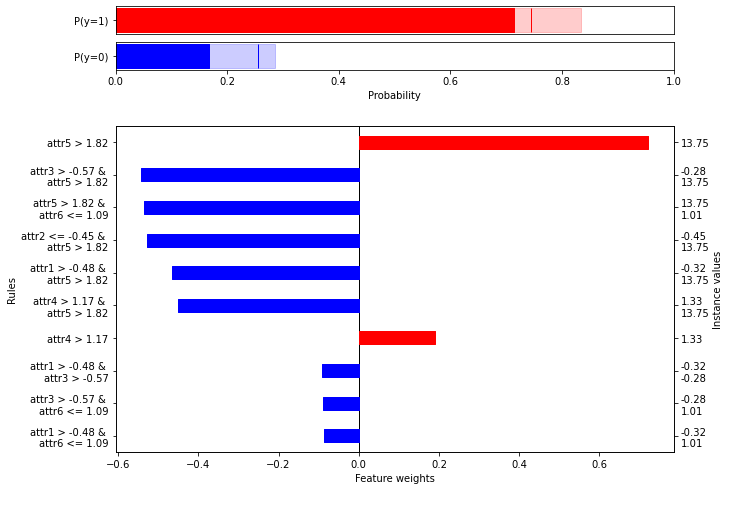

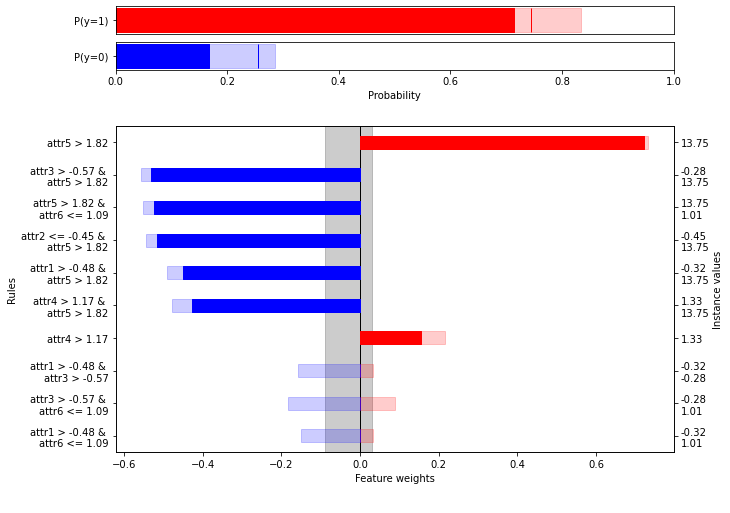

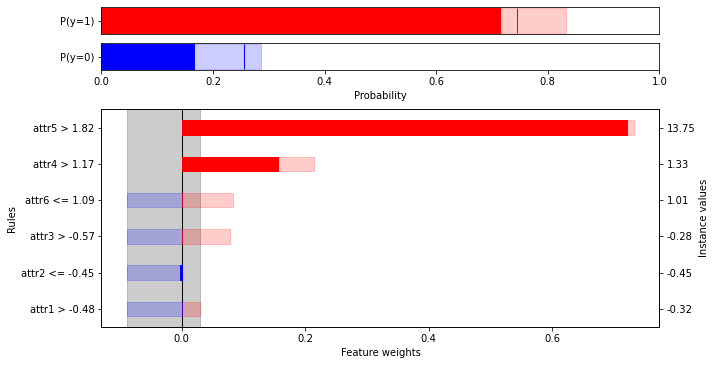

In [21]:
factual_explanations.add_conjunctions().plot_explanation(len(y_test)-1)
factual_explanations.plot_explanation(len(y_test)-1, uncertainty=True)
factual_explanations.remove_conjunctions().plot_explanation(len(y_test)-1, uncertainty=True)

#### Counterfactual Explanations
An alternative to factual rules is to extract counterfactual rules. 
`explain_counterfactual` can be called to get counterfactual rules with an appropriate discretizer automatically assigned. Note that the discretizer has changed. 

In [22]:
counterfactual_explanations = classifier.explain_counterfactual(X_test)
display(classifier)

WrapCalibratedExplainer(learner=RandomForestClassifier(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=classification
	                discretizer=<class 'lime.discretize.EntropyDiscretizer'>
	                model=RandomForestClassifier()
	                )

Counterfactuals are also visualized using the `plot_all`. Plotting an individual counterfactual explanation is done using `plot_explanation`, submitting the index to plot. Adding or removing conjunctions is done as before. 

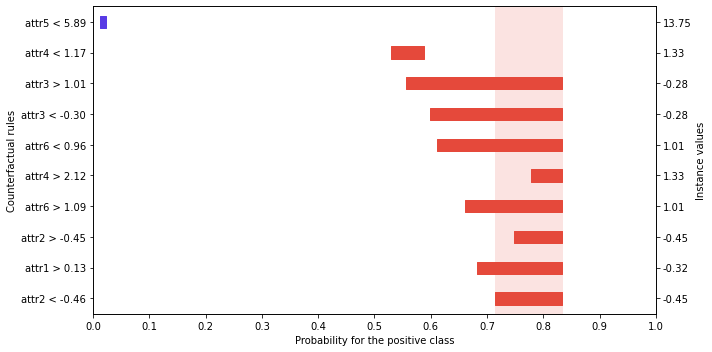

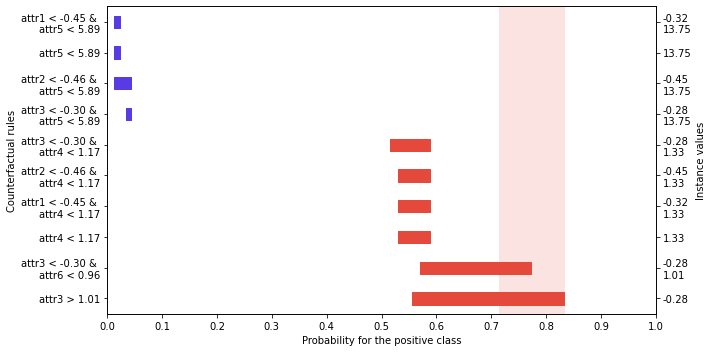

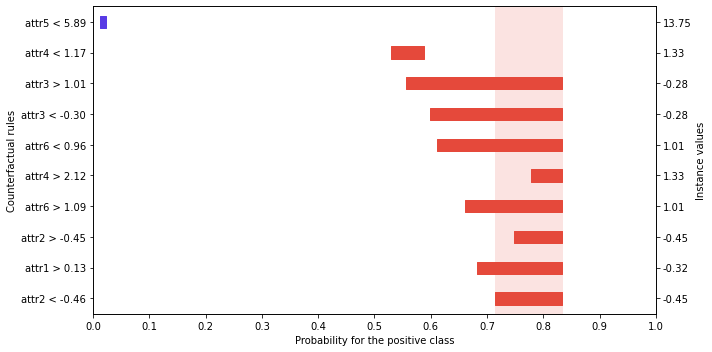

In [26]:
counterfactual_explanations.plot_explanation(len(y_test)-1)
counterfactual_explanations.add_conjunctions().plot_explanation(len(y_test)-1)

counterfactual_explanations.remove_conjunctions().plot_explanation(len(y_test)-1)

`calibrated_explanations` supports multiclass which is demonstrated in [demo_multiclass](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_multiclass.ipynb). That notebook also demonstrates how both feature names and target and categorical labels can be added to improve the interpretability. 